# **Imports & Helper Function**

In [1]:
# === Cell: Imports & Helper Function ===

# Basic libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def random_batch():
    """
    Samples a random mini‑batch of skip‑gram pairs.
    Returns one‑hot encoded inputs and integer labels.
    """
    inputs, labels = [], []
    # Choose random indices without replacement
    random_indices = np.random.choice(range(len(skip_grams)), batch_size, replace=False)

    for idx in random_indices:
        target_idx, context_idx = skip_grams[idx]
        inputs.append(np.eye(voc_size)[target_idx])  # one-hot vector for target word
        labels.append(context_idx)                   # context word index

    return inputs, labels


# **Word2Vec Model Definition**

In [2]:
# === Cell: Word2Vec Model Definition ===

class Word2Vec(nn.Module):
    def __init__(self):
        super(Word2Vec, self).__init__()
        # Maps one-hot input → dense embedding
        self.W = nn.Linear(voc_size, embedding_size, bias=False)
        # Maps embedding → vocabulary logits
        self.WT = nn.Linear(embedding_size, voc_size, bias=False)

    def forward(self, X):
        hidden = self.W(X)           # [batch_size, embedding_size]
        output = self.WT(hidden)     # [batch_size, voc_size]
        return output


# **Data Preparation**

In [3]:
# === Cell: Data Preparation ===

# Hyperparameters
batch_size = 2
embedding_size = 2

# Example sentences
sentences = [
    "apple banana fruit", "banana orange fruit", "orange banana fruit",
    "dog cat animal", "cat monkey animal", "monkey dog animal"
]

# Build vocabulary
word_sequence = " ".join(sentences).split()
word_list = list(set(word_sequence))
word_dict = {w: i for i, w in enumerate(word_list)}
voc_size = len(word_list)

# Generate skip-gram pairs (target, context)
skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target = word_dict[word_sequence[i]]
    contexts = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]
    for ctx in contexts:
        skip_grams.append([target, ctx])


# **Training Loop**

In [4]:
# === Cell: Training Loop ===

# Instantiate model, loss, and optimizer
model = Word2Vec()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train for 5000 epochs
for epoch in range(5000):
    inputs, labels = random_batch()
    inputs = torch.Tensor(inputs)            # [batch_size, voc_size]
    labels = torch.LongTensor(labels)        # [batch_size]

    optimizer.zero_grad()
    outputs = model(inputs)                  # forward pass
    loss = criterion(outputs, labels)        # compute cross-entropy loss

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch: {epoch+1:04d}, Loss = {loss.item():.6f}')

    loss.backward()                          # backpropagation
    optimizer.step()                         # update weights


<ipython-input-4-c807c18abd1e>:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  inputs = torch.Tensor(inputs)            # [batch_size, voc_size]


Epoch: 1000, Loss = 2.037715
Epoch: 2000, Loss = 1.703401
Epoch: 3000, Loss = 1.581577
Epoch: 4000, Loss = 1.142689
Epoch: 5000, Loss = 0.852097


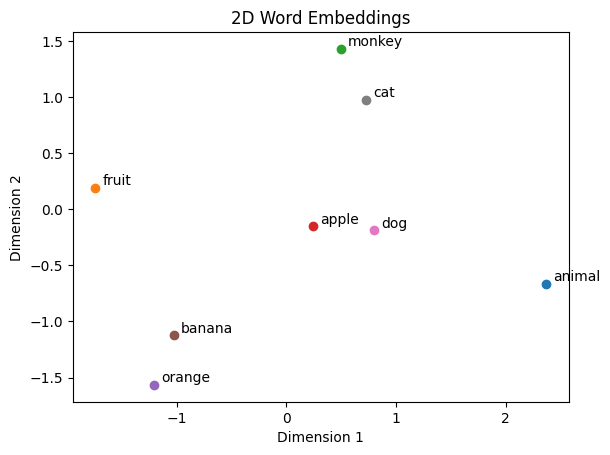

In [5]:
# === Cell: Plot Learned Embeddings ===

# Extract embedding weight matrix
embeddings = model.W.weight.data.numpy().T  # shape: [voc_size, embedding_size]

# Scatter plot each word in 2D embedding space
for i, word in enumerate(word_list):
    x, y = embeddings[i]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), textcoords='offset points', xytext=(5,2))

plt.title("2D Word Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()
